In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import latools as la
import pandas as pd
import uncertainties as un
import uncertainties.unumpy as unp

In [3]:
dir = 'dev_boron/carbonates_clean'
file = dir + '/20220223_001_v2_CarbTest_Standards.xlsx'
la.preprocessing.sanitise.Neptune_xlsx(file, 25000)

'Saved to: dev_boron/carbonates_clean/20220223_001_v2_CarbTest_Standards.csv'

In [4]:
# from latools import preprocessing
# file = 'dev_boron/carbonates_clean/20220223_001_v2_CarbTest_Standards.csv'
# preprocessing.split.by_regex(file, outdir=dir, split_pattern='Neptune Analysis Data Report', fname_pattern='Block-View - (Block: \d+).*')



In [5]:
dataformat = {
    "genfromtext_args": {
    "delimiter": ",",
    },
    "column_id": {
        "delimiter": ",",
        "timecolumn": 0,
        "name_row": 0,
        "pattern": "([0-9]{1,3}[A-z]{1,3}|[0-9.]{2,})"
    }}

In [6]:
laserlog = pd.read_csv(dir + '/20220223_CarbTest_Standards_log_20220223_190001.laserlog')
laserlog.columns = [s.strip() for s in laserlog.columns]
sample_names = laserlog.Comment.dropna().values
# sample_names = sample_names[:22]

In [7]:

# la.preprocessing.split.long_file(file.replace('xlsx','csv'), dataformat=dataformat, sample_list=sample_names, plot=True, analyte='10B', savedir=dir + '/split', passthrough=False, **autorange_args)


In [8]:
autorange_args = {
    'signal_id_mode': 'polynomial',
    'poly_noise_level': 2.5, 
    'poly_order': 3, 
    'std_above_baseline': 3, 
    'min_points': 3,
    'swin': 3,
    'transform': None,
    'plot': True,
}

dat = la.analyse(file.replace('xlsx','csv'), dataformat=dataformat, file_structure='long', names=sample_names, split_kwargs=autorange_args, srm_identifier='NIST', srm_file='latools/resources/SRM_GeoRem_Preferred_100523.csv')

--------------------------------------------------------------------------------
Starting analysis:
  Using custom srm_file (latools/resources/SRM_GeoRem_Preferred_100523.csv)
  Using custom dataformat dict


0it [00:00, ?it/s]

/home/oscar/GitHub/latools/dev_boron/carbonates_clean/20220223_001_v2_CarbTest_Standards.csv
dataformat dict provided - no read necessary.
Number of samples in list (171) does not match number of ablations (174).
  -> There are more ablations than samples...
     Removing data fragments to match sample list length.
       (Removed data fragments < 6 points long)
Success! 171 ablations identified.
Loading Data:
  171 Data Files Loaded: 16 standards, 155 samples
Analytes: 9.95 10.115 10B 10.54 11B
  Internal Standard: None


In [9]:
dat.despike()

Despiking:   0%|          | 0/171 [00:00<?, ?it/s]

In [10]:
dat.autorange('10B', swin=3, transform=None, signal_id_mode='polynomial', poly_noise_level=2., poly_order=3, std_above_baseline=3, on_mult=(3,1), off_mult=(1,3), mode='global', min_points=6)

In [11]:
# dat.trace_plots(ranges=True)

In [12]:
dat.bkg_calc_weightedmean(weight_fwhm=1500)

Plotting backgrounds:   0%|          | 0/5 [00:00<?, ?it/s]

(<Figure size 5130x750 with 1 Axes>,
 <Axes: title={'center': 'Points = raw data; Bars = stderr; Lines = Calculated Background; Envelope = Background stderr'}, xlabel='Time (s)', ylabel='Background Counts'>)

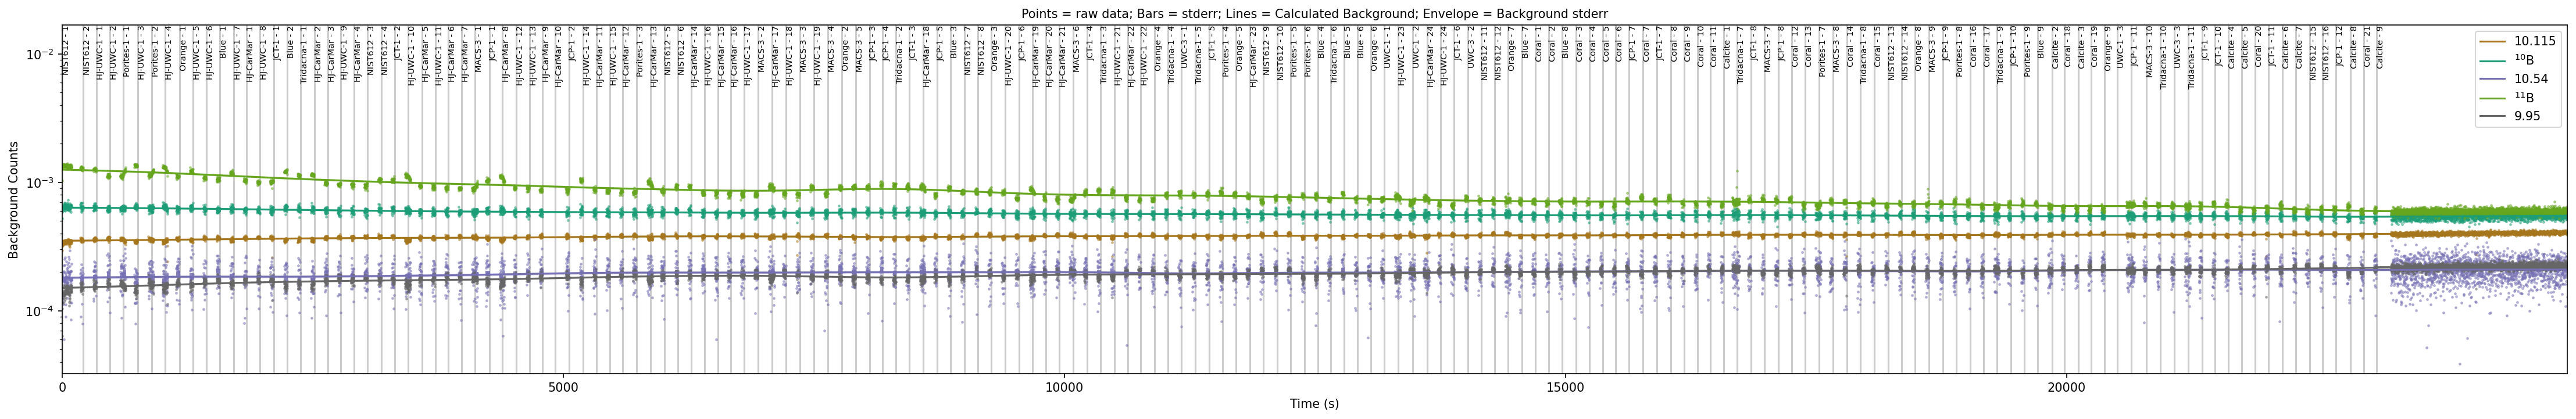

In [13]:
dat.bkg_plot()

In [14]:
dat.bkg_subtract()

Background Subtraction:   0%|          | 0/171 [00:00<?, ?it/s]

In [15]:
dat.analytes

{'10.115', '10.54', '10B', '11B', '9.95'}

In [16]:
dat._analyte_checker('10B')

{'10B'}

In [17]:
dat.ratio(internal_standard='10B', analytes='11B')

# mass bias correction to NIST SRM

#   11B and 10B in SRM databse - calibrate function needs to be able to cope with analyte ratios in database.
#   Should just work with 'Calibrate' function? 
#   Is linear interpolation of parameters sensible? 
#   Think about sensitivity drift correction?

Ratio Calculation:   0%|          | 0/171 [00:00<?, ?it/s]

In [531]:
dat.clear_calibration()

In [533]:
dat.calibrate(drift_correct='gauss_weighted', srms_used='NIST612', gauss_weight_fwhm=7000)

Applying Calibrations:   0%|          | 0/171 [00:00<?, ?it/s]

In [841]:
# calculate d11B (or 11/10 Ratio) multiplicative correction factor
# apply offset multiplier to mass-bias corrected data

dat.ratio(internal_standard='10.115', analytes='11B')
dat.ratio(internal_standard='10.54', analytes='11B')
dat.ratio(internal_standard='9.95', analytes='11B')

Ratio Calculation:   0%|          | 0/171 [00:00<?, ?it/s]

Ratio Calculation:   0%|          | 0/171 [00:00<?, ?it/s]

Ratio Calculation:   0%|          | 0/171 [00:00<?, ?it/s]

In [26]:
# dat.get_focus()

In [27]:
# dat.focus

In [28]:
# dat.samples

In [847]:
dat.srmdat

Value  Uncertainty Uncertainty_Type     Unit GeoReM_bibcode  \
SRM     Item                                                                    
NIST612 H2O       0.021          NaN              NaN     %m/m    GeoReM 5211   
        Na2O     13.700       0.3000            95%CL     %m/m    GeoReM 5211   
        Al2O3     2.030       0.0400            95%CL     %m/m    GeoReM 5211   
        SiO2     72.100       0.6000            95%CL     %m/m    GeoReM 5211   
        CaO      11.900       0.1000            95%CL     %m/m    GeoReM 5211   
...                 ...          ...              ...      ...            ...   
        Pb       38.570       0.2000            95%CL     ug/g    GeoReM 5211   
        Bi       30.200       2.3000            95%CL     ug/g    GeoReM 5211   
        Th       37.790       0.0800            95%CL     ug/g    GeoReM 5211   
        U        37.380       0.0800            95%CL     ug/g    GeoReM 5211   
        11B_10B   4.048       0.0021              2SD  mol/mol    GeoReM 2902   

                         Reference           M       g/g       g/g_err  \
SRM     Item                                                             
NIST612 H2O      Jochum et al 2011   18.015280  0.000210           NaN   
        Na2O     Jochum et al 2011   61.978940  0.137000  3.000000e-03   
        Al2O3    Jochum et al 2011  101.961276  0.020300  4.000000e-04   
        SiO2     Jochum et al 2011   60.084300  0.721000  6.000000e-03   
        CaO      Jochum et al 2011   56.077400  0.119000  1.000000e-03   
...                            ...         ...       ...           ...   
        Pb       Jochum et al 2011  207.200000  0.000039  2.000000e-07   
        Bi       Jochum et al 2011  208.980380  0.000030  2.300000e-06   
        Th       Jochum et al 2011  232.038100  0.000038  8.000000e-08   
        U        Jochum et al 2011  238.028910  0.000037  8.000000e-08   
        11B_10B  Jochum et al 2008         NaN       NaN           NaN   

                        mol/g     mol/g_err  
SRM     Item                                 
NIST612 H2O      1.165677e-05           NaN  
        Na2O     4.420857e-03  9.680710e-05  
        Al2O3    3.981900e-04  7.846120e-06  
        SiO2     1.199981e-02  9.985970e-05  
        CaO      2.122067e-03  1.783250e-05  
...                       ...           ...  
        Pb       1.861486e-07  9.652510e-10  
        Bi       1.445112e-07  1.100582e-08  
        Th       1.628612e-07  3.447710e-10  
        U        1.570397e-07  3.360936e-10  
        11B_10B           NaN           NaN  

[70 rows x 11 columns]

4.048

In [850]:
NIST951a = 1 / 0.2473

srm_d11B = {
    # 'NIST612': un.ufloat(-0.26, 0.13/2),
    'NIST612': (un.ufloat(4.048, 0.001) / NIST951a - 1) * 1000,
    'MACS': un.ufloat(-0.57, 0.11/2),
    'JCT': un.ufloat(16.3, 0.55/2),
    'JCP': un.ufloat(24.3, 0.42/2),
    # 'UWC': un.ufloat(7.77, 0.89/2),
}

srm_colours = {
    'NIST612': 'C0',
    'MACS': 'C1',
    'JCT': 'C2',
    'JCP': 'C3',
    # 'UWC': 'C4',
}

srm_R11B = {k: (v / 1000 + 1) * NIST951a for k, v in srm_d11B.items()}

In [72]:
# outlier rejection in regression?

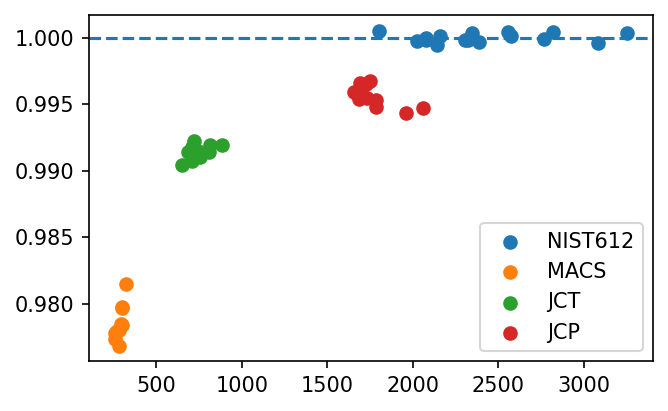

In [860]:
fig, ax = plt.subplots()

# samples = [s for s in dat.samples if 'JCT' in s or 'UWC' in s or 'JCP' in s or 'MACS' in s]
# samples = dat.samples

for srm in srm_d11B:
    samples = [s for s in dat.samples if srm in s]

    for s in samples:
        d = dat.data[s]
        # x = np.nanmean(d.data['ratios']['11B_10.54'])
        x = np.nanmean(d.data['ratios']['11B_10.115'])
        y = np.nanmean(d.data['calibrated']['11B_10B']) / srm_R11B[srm]
        ax.scatter(la.nominal_values(x), la.nominal_values(y), color=srm_colours[srm])

for k, v in srm_colours.items():
    ax.scatter([],[], color=v, label=k)

ax.axhline(1, ls='--', color=srm_colours['NIST612'])
    
ax.legend()

In [ ]:
fig, ax = plt.subplots()

for srm in srm_d11B:
    samples = [s for s in dat.samples if srm in s]

    for s in samples:
        d = dat.data[s]
        # x = np.nanmean(d.data['ratios']['11B_10.54'])
        x = np.nanmean(d.data['ratios']['11B_10.115'])
        y = np.nanmean(d.data['calibrated']['11B_10B'])
        ax.scatter(la.nominal_values(x), la.nominal_values(y), color=srm_colours[srm])
    
    ax.axhline(la.nominal_values(srm_R11B[srm]), ls='--', color=srm_colours[srm], label=srm)
    
ax.legend()

In [866]:
srm_R11B['JCT']

4.109583501819652+/-0.0011120097048119694

In [29]:
# dat.trace_plots()